### Team: <br>
1. Dina Zakria 
2. Ahmed Sameh
3. Abdelrhman Amr

<br> **Naser City Branch - AI-Pro**

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

In [8]:
# Imports
import cv2
import os
from tqdm import tqdm
from glob import glob
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

## Loading Dataset

In [2]:
df = pd.read_csv("../input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [35]:
# Group bt Drivers/ Test Subjects
by_drivers = df.groupby('subject')

unique_drivers = by_drivers.groups.keys()

print("There are: ", len(unique_drivers), " unique drivers")
print('These are the numbers of each test subject: \n',round(by_drivers.count()['classname']))

There are:  26  unique drivers
These are the numbers of each test subject: 
 subject
p002     725
p012     823
p014     876
p015     875
p016    1078
p021    1237
p022    1233
p024    1226
p026    1196
p035     848
p039     651
p041     605
p042     591
p045     724
p047     835
p049    1011
p050     790
p051     920
p052     740
p056     794
p061     809
p064     820
p066    1034
p072     346
p075     814
p081     823
Name: classname, dtype: int64


In [3]:
# Setting the number of classes to be classified.
NUMBER_CLASSES = 10

> ### Helper Functions

In [4]:
# Read with opencv
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    """
    Function that return an opencv image from the path and the right number of dimension
    """
    if color_type == 1: # Loading as Grayscale image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3: # Loading as color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converts to RGB

    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

# Loading Training dataset
def load_train(img_rows, img_cols, color_type=3):
    """
    Return train images and train labels from the original path
    """
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/train/c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    """
    Load + categorical + split
    """
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10) #categorical train label
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split into train and test
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('../input/state-farm-distracted-driver-detection/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [5]:
# dimension of images
img_rows = 128 
img_cols = 128

color_type = 1 # grey
nb_test_samples = 200

In [8]:
# loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

# loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:21<03:17, 21.90s/it]

Loading directory c1


 20%|██        | 2/10 [00:42<02:47, 20.90s/it]

Loading directory c2


 30%|███       | 3/10 [01:02<02:26, 20.87s/it]

Loading directory c3


 40%|████      | 4/10 [01:24<02:05, 20.95s/it]

Loading directory c4


 50%|█████     | 5/10 [01:45<01:44, 20.99s/it]

Loading directory c5


 60%|██████    | 6/10 [02:05<01:22, 20.75s/it]

Loading directory c6


 70%|███████   | 7/10 [02:25<01:02, 20.68s/it]

Loading directory c7


 80%|████████  | 8/10 [02:43<00:39, 19.84s/it]

Loading directory c8


 90%|█████████ | 9/10 [03:00<00:18, 18.92s/it]

Loading directory c9


  0%|          | 200/79726 [00:02<15:13, 87.09it/s]


## EDA

In [11]:
x_train_size = len(x_train)
x_test_size = len(x_test)
test_files_size = len(np.array(glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/test', '*.jpg'))))

> ## Statistical numbers about the data

In [41]:
print('There are %s total images.' %(x_train_size + x_test_size + test_files_size))
print('There are %d total training categories.' %NUMBER_CLASSES )
print('There are %d training images.' % x_train_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.
There are 10 total training categories.
There are 17939 training images.
There are 4485 validation images.
There are 79726 test images.


> ## Data Visualization

In [42]:
import plotly.express as px

px.histogram(df, x="classname", color="classname", title="Number of images by categories ")

> **Comment:** As we can see from the figure above, the classes are well balanced.

In [43]:
# Number of Images by Drivers / Test Subject

drivers_id = pd.DataFrame((df['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

In [44]:
# np.save('./x_train.npy',x_train)
# np.save('./y_train.npy',y_train)
# np.save('./x_test.npy',x_test)
# np.save('./y_test.npy',y_test)

# Fully connected layer

In [45]:
# x_train = np.load('../input/dl-project/x_train.npy').astype('float32')/255
# y_train = np_utils.to_categorical(np.load('../input/dl-project/y_train.npy'))
# x_val = np.load('../input/dl-project/x_test.npy').astype('float32')/255
# y_val = np_utils.to_categorical(np.load('../input/dl-project/y_test.npy'))

In [46]:
# x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)/255
# y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
# x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)/255
# y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

In [14]:
no_epoch = 20
batch_size = 64
img_height = img_rows
img_width = img_cols
channels = 1

> ## Building initial model

In [48]:
# temp
x_train_FC = x_train.reshape((x_train_size, img_rows*img_cols*1))
x_train_FC = x_train_FC.astype('float32')/255
x_val_FC = x_test.reshape((x_test_size, img_rows*img_cols*1))
x_val_FC = x_val_FC.astype('float32')/255
y_val = y_test

In [49]:
FC_init1 = Sequential()
# FC_init.add(Flatten())
FC_init1.add(Dense(512, activation='relu', name='Layer_1', input_shape=(img_width * img_height * channels,)))
FC_init1.add(Dense(256, activation='relu', name='Layer_2'))
FC_init1.add(Dense(128, activation='relu', name='Layer_3'))
FC_init1.add(Dense(10, activation='softmax'))

In [50]:
opt = keras.optimizers.Adam(learning_rate=10e-3)
FC_init1.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [51]:
FC_init1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
Layer_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
Layer_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 8,554,634
Trainable params: 8,554,634
Non-trainable params: 0
_________________________________________________________________


In [19]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

In [53]:
History = FC_init1.fit(x_train_FC,y_train, validation_data=(x_val_FC,y_val), verbose = 1, epochs = no_epoch, batch_size = batch_size,callbacks=[early_stopping])

2022-07-09 15:54:55.183676: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1175650304 exceeds 10% of free system memory.
2022-07-09 15:54:56.663015: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1175650304 exceeds 10% of free system memory.


Epoch 1/20
281/281 [==============================] - 3s 8ms/step - loss: 5.5296 - accuracy: 0.2243 - val_loss: 1.5120 - val_accuracy: 0.4062
Epoch 2/20
281/281 [==============================] - 2s 6ms/step - loss: 1.3272 - accuracy: 0.4610 - val_loss: 1.4426 - val_accuracy: 0.4586
Epoch 3/20
281/281 [==============================] - 2s 5ms/step - loss: 0.9978 - accuracy: 0.5881 - val_loss: 0.7785 - val_accuracy: 0.6878
Epoch 4/20
281/281 [==============================] - 2s 5ms/step - loss: 0.8455 - accuracy: 0.6648 - val_loss: 0.6420 - val_accuracy: 0.7628
Epoch 5/20
281/281 [==============================] - 2s 6ms/step - loss: 0.6310 - accuracy: 0.7476 - val_loss: 0.5568 - val_accuracy: 0.7786
Epoch 6/20
281/281 [==============================] - 2s 6ms/step - loss: 0.6660 - accuracy: 0.7493 - val_loss: 0.6714 - val_accuracy: 0.7402
Epoch 7/20
281/281 [==============================] - 2s 6ms/step - loss: 0.6010 - accuracy: 0.7687 - val_loss: 0.4987 - val_accuracy: 0.8004
Epoch 

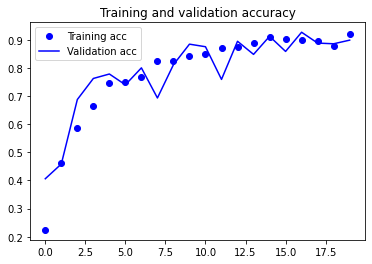

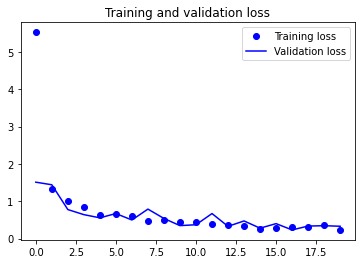

In [54]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Predict 

In [55]:
test_files.dtype

dtype('uint8')

In [56]:
test_files[0].shape

(128, 128, 1)

In [57]:
x_train.dtype

dtype('uint8')

In [58]:
print(len(test_files))
print(test_files_size)


200
79726


In [59]:
test_imgs = test_files.reshape((nb_test_samples, img_rows*img_cols*1))
test_imgs = test_imgs.astype('float32')/255


In [60]:
pred = FC_init1.predict(test_imgs)
pred[0]

array([6.9266053e-18, 7.0061728e-17, 1.4017497e-18, 1.3540135e-24,
       7.8824256e-16, 1.0000000e+00, 2.6572052e-13, 4.4243718e-13,
       8.0378048e-15, 3.9696921e-08], dtype=float32)

## Building Baseline CNN Model

In [12]:
# temp
x_train_CNN = x_train.reshape((x_train_size, img_rows,img_cols,1))
x_train_CNN = x_train_CNN.astype('float32')/255
x_val_CNN = x_test.reshape((x_test_size, img_rows,img_cols,1))
x_val_CNN = x_val_CNN.astype('float32')/255
y_val = y_test

In [15]:
CNN_model = Sequential()
CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channels)))
CNN_model.add(MaxPooling2D((2, 2)))
CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D((2, 2)))
CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(10, activation='softmax'))


In [16]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
CNN_model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [20]:
History_CNN = CNN_model.fit(x_train_CNN,y_train, validation_data=(x_val_CNN,y_val), verbose = 1, epochs = no_epoch, batch_size = batch_size,callbacks=[early_stopping])

2022-07-09 16:02:36.715808: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1175650304 exceeds 10% of free system memory.
2022-07-09 16:02:37.942863: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1175650304 exceeds 10% of free system memory.
2022-07-09 16:02:38.887019: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-07-09 16:02:40.211601: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


281/281 [==============================] - 14s 22ms/step - loss: 1.4355 - accuracy: 0.5346 - val_loss: 0.6018 - val_accuracy: 0.8361
Epoch 2/20
281/281 [==============================] - 5s 19ms/step - loss: 0.3551 - accuracy: 0.9062 - val_loss: 0.2434 - val_accuracy: 0.9315
Epoch 3/20
281/281 [==============================] - 5s 19ms/step - loss: 0.1592 - accuracy: 0.9595 - val_loss: 0.1272 - val_accuracy: 0.9637
Epoch 4/20
281/281 [==============================] - 5s 19ms/step - loss: 0.0905 - accuracy: 0.9765 - val_loss: 0.0927 - val_accuracy: 0.9766
Epoch 5/20
281/281 [==============================] - 5s 19ms/step - loss: 0.0583 - accuracy: 0.9849 - val_loss: 0.0840 - val_accuracy: 0.9786
Epoch 6/20
281/281 [==============================] - 5s 19ms/step - loss: 0.0430 - accuracy: 0.9877 - val_loss: 0.0964 - val_accuracy: 0.9737
Epoch 7/20
281/281 [==============================] - 5s 19ms/step - loss: 0.0227 - accuracy: 0.9949 - val_loss: 0.0587 - val_accuracy: 0.9855
Epoch 8/2

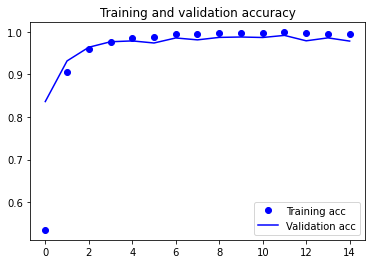

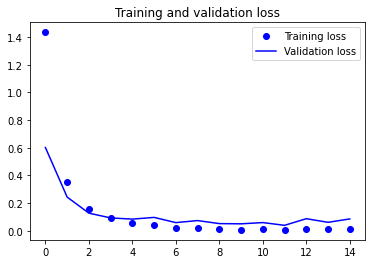

In [21]:
acc = History_CNN.history['accuracy']
val_acc = History_CNN.history['val_accuracy']
loss = History_CNN.history['loss']
val_loss = History_CNN.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
test_imgs = test_files.reshape((nb_test_samples, img_rows,img_cols,1))
test_imgs = test_imgs.astype('float32')/255


In [23]:
pred = CNN_model.predict(test_imgs)
pred[0]

array([2.1550963e-19, 2.2860703e-25, 1.1128525e-14, 7.7629120e-24,
       3.1549574e-12, 1.0000000e+00, 1.1903187e-15, 4.2786334e-20,
       5.4129446e-15, 3.2234591e-13], dtype=float32)

## Data Augmentation

In [9]:
# Version 01

Traindatagen = ImageDataGenerator(
      featurewise_center = True,
      featurewise_std_normalization = True,
      rescale = 1.0/255,
      rotation_range=20,
      shear_range=0.2,
      horizontal_flip=True,
      vertical_flip=False,
      fill_mode='nearest')


Valdatagen =  ImageDataGenerator(featurewise_center = True, 
                                 featurewise_std_normalization = True, 
                                 rescale=1.0/ 255, 
                                 validation_split = 0.2)

# Transfer learning using VGG16

In [10]:
# loading train images
x_train_vgg, x_test_vgg, y_train_vgg, y_test_vgg = read_and_normalize_train_data(img_rows, img_cols, 3)

# loading validation images
# test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, 3)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:29<04:23, 29.28s/it]

Loading directory c1


 20%|██        | 2/10 [00:56<03:44, 28.12s/it]

Loading directory c2


 30%|███       | 3/10 [01:23<03:11, 27.40s/it]

Loading directory c3


 40%|████      | 4/10 [01:49<02:42, 27.16s/it]

Loading directory c4


 50%|█████     | 5/10 [02:15<02:13, 26.72s/it]

Loading directory c5


 60%|██████    | 6/10 [02:42<01:46, 26.57s/it]

Loading directory c6


 70%|███████   | 7/10 [03:08<01:19, 26.36s/it]

Loading directory c7


 80%|████████  | 8/10 [03:31<00:50, 25.35s/it]

Loading directory c8


 90%|█████████ | 9/10 [03:52<00:24, 24.13s/it]

Loading directory c9


100%|██████████| 10/10 [04:16<00:00, 25.70s/it]


In [11]:
train_generator = Traindatagen.flow(x_train_vgg, y_train_vgg, batch_size = 256)
val_generator = Valdatagen.flow(x_test_vgg, y_test_vgg, batch_size = 64)

In [12]:
epochs = 40
train_bs = 256
valdi_bs = 64

In [13]:
from keras.applications.vgg16 import VGG16

def classificationModel():
    inp = keras.layers.Input(shape=(128, 128, 3))
    vgg = VGG16(weights='imagenet',
                  include_top=False,
                  input_tensor = inp,
                  input_shape=(128, 128, 3))
    vgg.trainable = False
    
    x = vgg.get_layer('block5_pool').output
    x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    output = keras.layers.Dense(10, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs = inp, outputs=output)

    return model
    

In [14]:
keras.backend.clear_session()
model = classificationModel()
model.summary()

2022-07-09 16:21:59.209538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 16:21:59.328687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 16:21:59.329769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 16:21:59.332026: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [15]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer='rmsprop',
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])

In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [17]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=3,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

## CNN Visualization

In [18]:
%%capture
!pip install wandb

In [19]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [20]:
class GradCAM:
    """
    Reference:
        https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
    """

    def __init__(self, model, layerName):
        self.model = model
        self.layerName = layerName

        self.gradModel = tf.keras.models.Model(inputs=[self.model.inputs],
                                               outputs=[self.model.get_layer(self.layerName).output, self.model.output])

    def compute_heatmap(self, image, classIdx, eps=1e-8):
        with tf.GradientTape() as tape:
            tape.watch(self.gradModel.get_layer(self.layerName).variables)
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = self.gradModel(inputs)

            if len(predictions) == 1:
                # Binary Classification
                loss = predictions[0]
            else:
                loss = predictions[:, classIdx]

        grads = tape.gradient(loss, convOutputs)

        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        return heatmap


    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_HOT):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        return (heatmap, output)

In [21]:
class GRADCamLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, layer_name):
      super(GRADCamLogger, self).__init__()
      self.validation_data = validation_data
      self.layer_name = layer_name

    def on_epoch_end(self, logs, epoch):
      images = []
      grad_cam = []

      ## Initialize GRADCam Class
      cam = GradCAM(model, self.layer_name)

      for image in self.validation_data:
        image = np.expand_dims(image, 0)
        pred = model.predict(image)
        classIDx = np.argmax(pred[0])
  
        ## Compute Heatmap
        heatmap = cam.compute_heatmap(image, classIDx)
        
        image = image.reshape(image.shape[1:])
        image = image*255
        image = image.astype(np.uint8)

        ## Overlay heatmap on original image
        heatmap = cv2.resize(heatmap, (image.shape[0],image.shape[1]))
        (heatmap, output) = cam.overlay_heatmap(heatmap, image, alpha=0.5)

        images.append(image)
        grad_cam.append(output)

      wandb.log({"images": [wandb.Image(image)
                            for image in images]})
      wandb.log({"gradcam": [wandb.Image(cam)
                            for cam in grad_cam]})

In [22]:
## Prepare sample images to run your GradCam on. 
sample_images, sample_labels = val_generator[20]
sample_images.shape, sample_labels.shape

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


((64, 128, 128, 3), (64, 10))

> ## Interactive Monitoring Window <br>
You can scroll up and down across charts, view system utilization, model architecture. <br>
**First Set of Panels (Charts):** <br>
> 1. Training accuracy, Validation accuracy vs Step
> 2. Training loss, Validation loss vs Step
> 3. Epochs vs Step

> **Second Set of Panels (Activation maps):** <br>
> 1. Gradient Cam activation maps per class vs Step
> 2. Images vs Step
> 3. Examples vs Step

In [23]:
wandb.init(project="test", entity="team-7")

wandb: Currently logged in as: z1z (team-7). Use `wandb login --relogin` to force relogin


> ## Accuracy <br>
- The transfer Learning using VGG16 conv_base and the augmented data reached a validation **accuracy** of **98.59%**

In [24]:
# History_Rs = resnetRs.fit(train_generator,
#          validation_data=val_generator,
#          steps_per_epoch=len(x_train_rs) // train_bs, epochs=epochs,
#           validation_steps =len(x_test_rs)//valdi_bs, verbose = 1)


history = model.fit(train_generator,
                          validation_data=val_generator,
                          steps_per_epoch=len(x_train_vgg) // train_bs, 
                          epochs=epochs,
                          validation_steps =len(x_test_vgg)//valdi_bs, 
                          verbose = 1,
                          callbacks=[WandbCallback(data_type="image", validation_data=(sample_images, sample_labels)),
                                     GRADCamLogger(sample_images, layer_name='block5_conv3'),
                                     early_stopping])


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.
2022-07-09 16:22:47.379185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-07-09 16:22:49.934481: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


70/70 [==============================] - 86s 1s/step - loss: 1.7221 - accuracy: 0.4663 - val_loss: 1.1532 - val_accuracy: 0.7379
Epoch 2/40
70/70 [==============================] - 69s 986ms/step - loss: 0.9524 - accuracy: 0.7866 - val_loss: 0.6936 - val_accuracy: 0.8737
Epoch 3/40
70/70 [==============================] - 69s 985ms/step - loss: 0.6508 - accuracy: 0.8687 - val_loss: 0.4959 - val_accuracy: 0.9040
Epoch 4/40
70/70 [==============================] - 70s 986ms/step - loss: 0.4859 - accuracy: 0.9045 - val_loss: 0.3820 - val_accuracy: 0.9232
Epoch 5/40
70/70 [==============================] - 70s 988ms/step - loss: 0.3900 - accuracy: 0.9284 - val_loss: 0.3060 - val_accuracy: 0.9442
Epoch 6/40
70/70 [==============================] - 71s 1s/step - loss: 0.3376 - accuracy: 0.9326 - val_loss: 0.2645 - val_accuracy: 0.9504
Epoch 7/40
70/70 [==============================] - 70s 990ms/step - loss: 0.2877 - accuracy: 0.9463 - val_loss: 0.2410 - val_accuracy: 0.9482
Epoch 8/40
70/70

In [ ]:
model.save('./vgg_tl_model.h5')

In [ ]:
new_model = tf.keras.models.load_model('./my_model.h5')

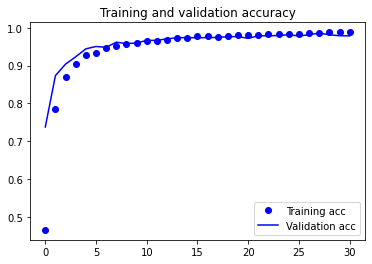

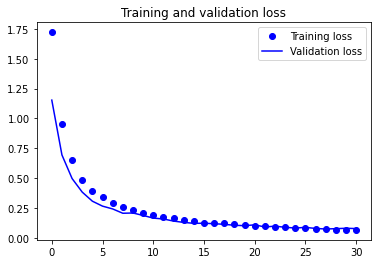

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
# Thank You !!